# Capital Bike Share Data Exploration

## Background

**Goal**: Predict bike usage across time using regression models

**Available Data**:

- X: 
    - datetime - hourly date + timestamp  
    - season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
    - holiday - whether the day is considered a holiday
    - workingday - whether the day is neither a weekend nor holiday
    - weather 
        - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
        - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
        - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
        - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
    - temp - temperature in Celsius
    - atemp - "feels like" temperature in Celsius
    - humidity - relative humidity
    - windspeed - wind speed
- Y: 
    - casual - number of non-registered user rentals initiated
    - registered - number of registered user rentals initiated
    - **count - number of total rentals**

## First Steps:

- Read data
- Check for:
    - Types
    - Completeness
    - Correlation / Co-linearity

In [308]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Read Data

In [309]:
path_data = "../01_data/train.csv"
rentals = pd.read_csv(path_data)
rentals['datetime'] = pd.to_datetime(rentals['datetime'])

## QC Checks

In [310]:
rentals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


In [311]:
rentals.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [312]:
rentals.isna().sum().sum(), rentals.isnull().sum().sum()

(0, 0)

In [313]:
print(rentals.weather.value_counts())

# flatten type 4 into type 3

rentals.weather = rentals.weather.replace(4, 3)

print(rentals.weather.value_counts())



1    7192
2    2834
3     859
4       1
Name: weather, dtype: int64
1    7192
2    2834
3     860
Name: weather, dtype: int64


In [314]:
rentals['workingday_adj'] = rentals['workingday'] + 1

## EDA

### Visual

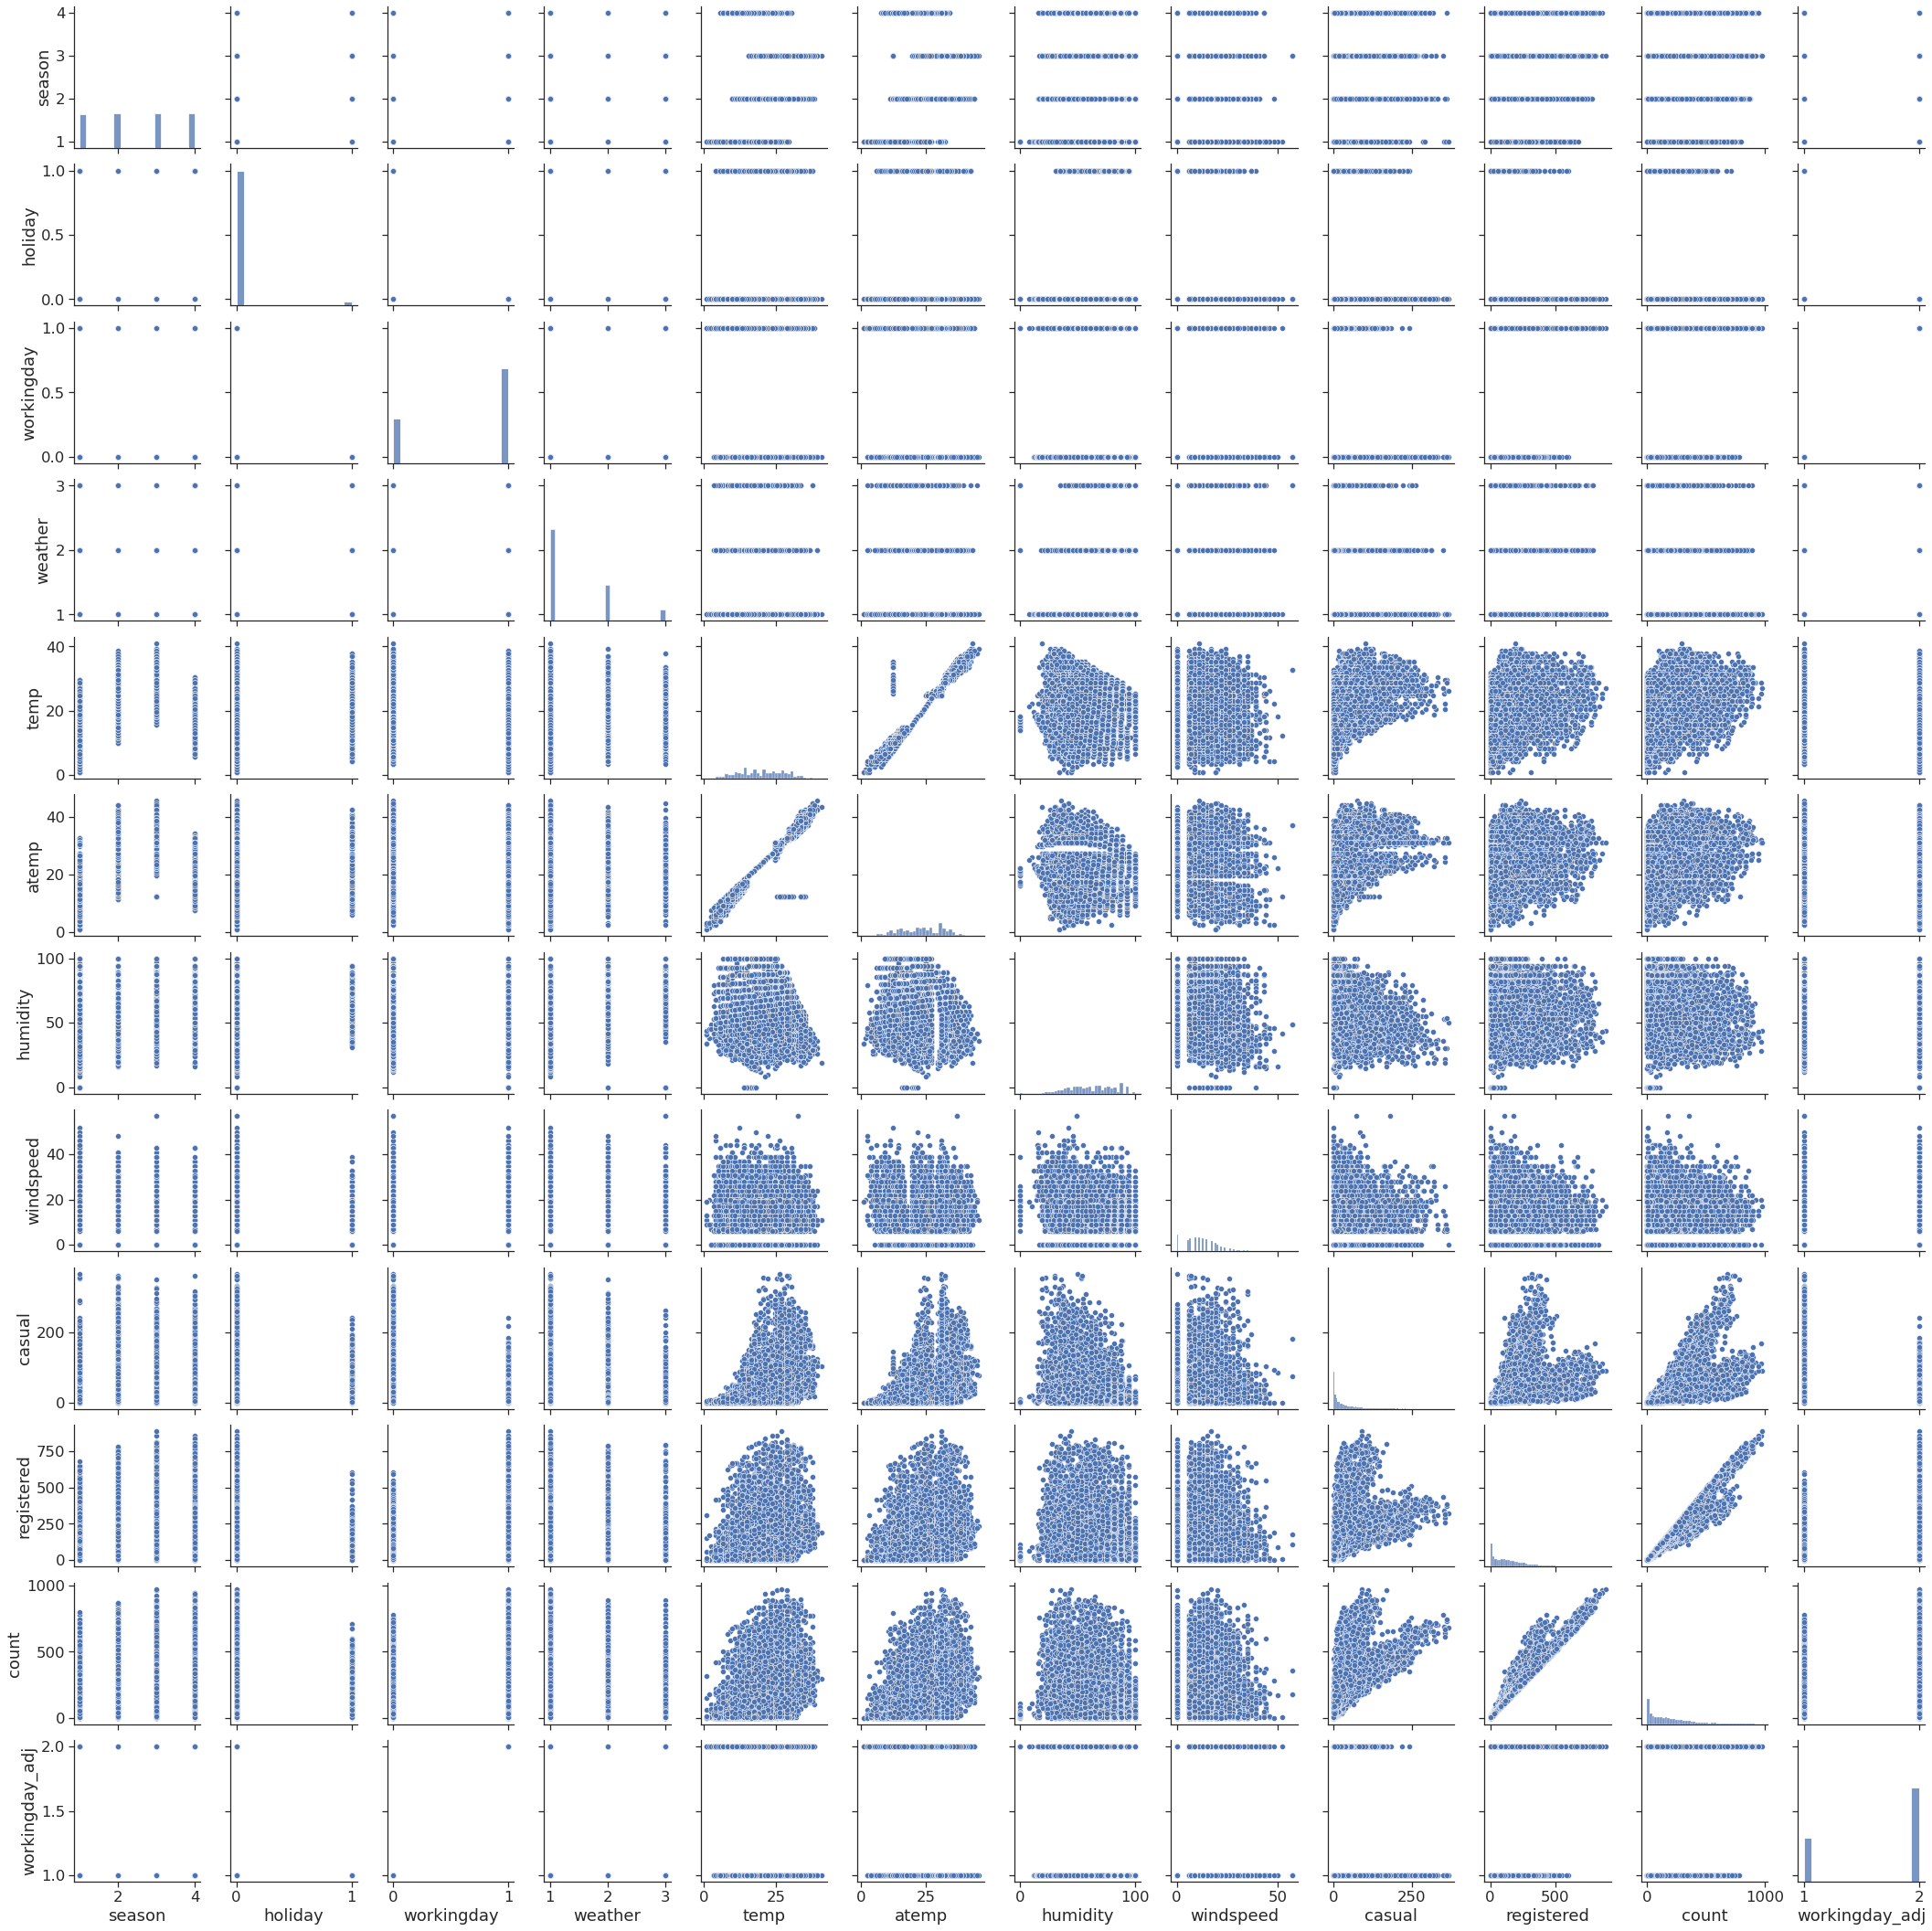

In [315]:
# grab numeric features


sns.pairplot(data = rentals)

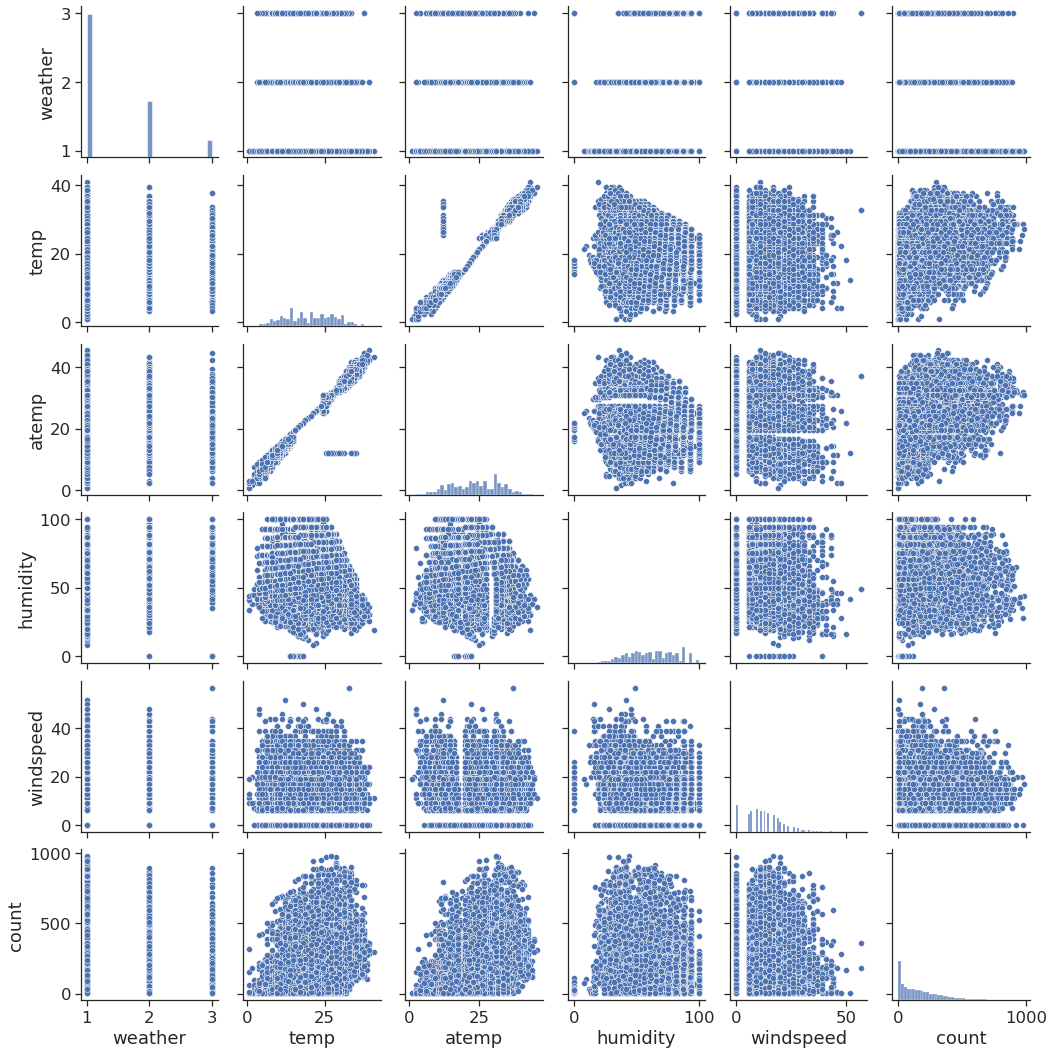

In [316]:

rentals_numerics = ['weather', 'temp', 'atemp', 'humidity', 'windspeed', 'count']

sns.pairplot(data = rentals, vars = rentals_numerics)

/home/alex/.conda/envs/spiced/lib/python3.8/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


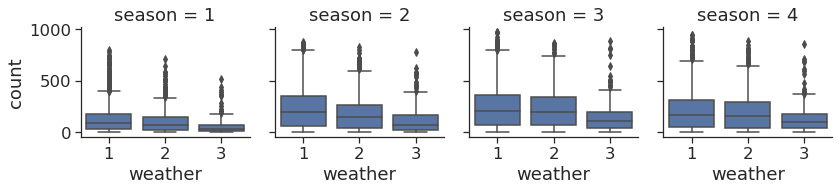

In [317]:
g = sns.FacetGrid(data = rentals[['weather', 'holiday', 'temp', 'windspeed', 'count', 'workingday', 'season']], col = 'season')
g.map(sns.boxplot,
    'weather',
    'count'


)

useful to include interactions for season*hour and hour * workingday

## Feature Engineering

- humidty = 0 at air temps above 12 degC are highly unlikely; remove obs or fill in with predicted values from temp

In [318]:
# from https://danvatterott.com/blog/2018/05/03/regression-of-a-proportion-in-python/ via
# https://stats.idre.ucla.edu/stata/faq/how-does-one-do-regression-when-the-dependent-variable-is-a-proportion/
import statsmodels.api as sm

humidity_clean = rentals.humidity[rentals.humidity > 1] / 100
temp_clean = rentals.temp[rentals.humidity > 1]

linear_glm = sm.GLM(humidity_clean, temp_clean)
linear_result = linear_glm.fit()
binom_glm = sm.GLM(humidity_clean, temp_clean, family=sm.families.Binomial())
binom_results = binom_glm.fit()


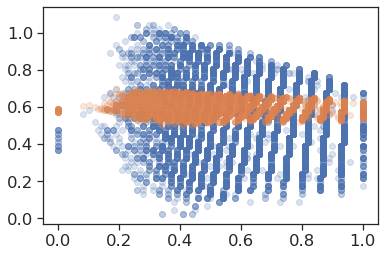

In [319]:
# plot results

rentals.humidity/100
plt.plot(rentals.humidity/100, linear_result.predict(rentals.temp), 'o', alpha=0.2)
plt.plot(rentals.humidity/100, binom_results.predict(rentals.temp), 'o', alpha=0.2)


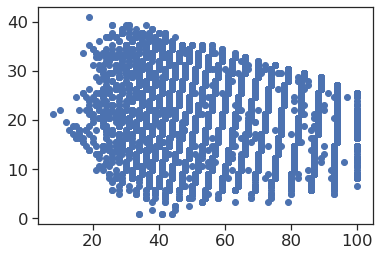

In [320]:

# binom results look too tightly constrained; using linear to replace humidty

rentals['humidity_adj'] = rentals.humidity

rentals.loc[rentals['humidity'] < 1, 'humidity_adj'] = linear_result.predict(rentals.loc[rentals['humidity'] < 1, 'temp'])*100


plt.plot(rentals.humidity_adj, rentals.temp, 'o')

<AxesSubplot:xlabel='windspeed', ylabel='Count'>

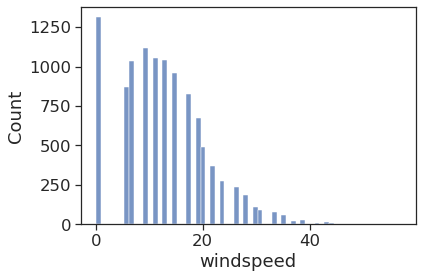

In [321]:
# inspect windspeed

sns.histplot(rentals, x = 'windspeed')

# could bin into calm < 5; 5 <= windy < 30; stormy >= 30

### Time features

- add Hour, Day, Month categories

In [322]:
# make function that cycles through time attrs and then adds a column to the df

def make_time_cols(time_att, time_series):
    
    feature_list = []

    for ta in time_att:
        try:

            dtobj = getattr(time_series, 'dt')

            feature_list.append(pd.Series(getattr(dtobj,ta), name = ta))
        except AttributeError:
            print(f'Time Attribute not present: {ta}')

    return pd.concat(feature_list, axis = 1)

In [323]:
time_atts = make_time_cols(time_att= ['year', 'dayofyear', 'month', 'day', 'weekday', 'hour'], time_series = rentals.datetime)

rentals = pd.concat([rentals, time_atts], axis = 1)
rentals['hour'] = rentals['hour'] + 1 # for polyfeatures



In [324]:
rentals.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,workingday_adj,humidity_adj,year,dayofyear,month,day,weekday,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,1,81.0,2011,1,1,1,5,1
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1,80.0,2011,1,1,1,5,2
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,1,80.0,2011,1,1,1,5,3
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,1,75.0,2011,1,1,1,5,4
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,1,75.0,2011,1,1,1,5,5


In [325]:
rentals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   datetime        10886 non-null  datetime64[ns]
 1   season          10886 non-null  int64         
 2   holiday         10886 non-null  int64         
 3   workingday      10886 non-null  int64         
 4   weather         10886 non-null  int64         
 5   temp            10886 non-null  float64       
 6   atemp           10886 non-null  float64       
 7   humidity        10886 non-null  int64         
 8   windspeed       10886 non-null  float64       
 9   casual          10886 non-null  int64         
 10  registered      10886 non-null  int64         
 11  count           10886 non-null  int64         
 12  workingday_adj  10886 non-null  int64         
 13  humidity_adj    10886 non-null  float64       
 14  year            10886 non-null  int64         
 15  da

In [326]:
rentals.year.unique()

array([2011, 2012])

### Data Exploration excursion

/home/alex/.conda/envs/spiced/lib/python3.8/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


<Figure size 1080x1080 with 0 Axes>

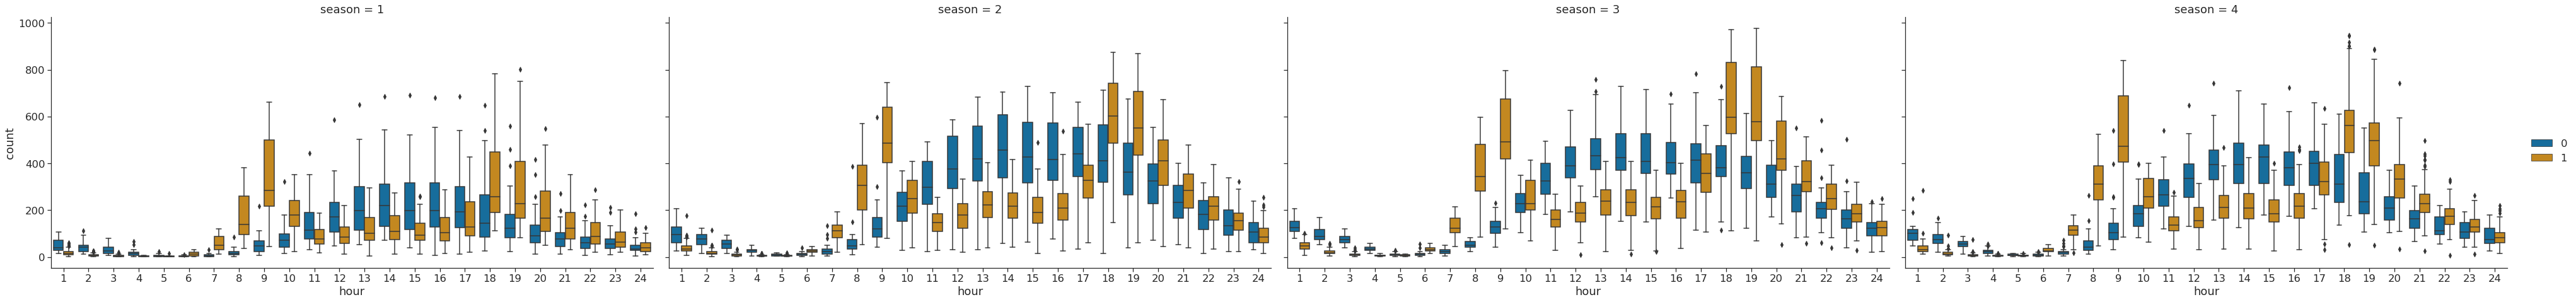

In [327]:
plt.figure(figsize = (15,15))

sns.set(font_scale = 1.5, style = 'ticks')

g = sns.FacetGrid(data = rentals[[
    'weather',
    'holiday',
    'temp',
    'windspeed',
    'count',
    'workingday',
    'season',
    'hour']],
    col = 'season',
    height = 7,
    aspect = 2)
g.map(sns.boxplot,
    'hour',
    'count',
    'workingday',
    palette = 'colorblind',
    hue_order = [0, 1]


)

g.add_legend()


# Model Development

## Imports

In [328]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PoissonRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_poisson_deviance
from sklearn.metrics import r2_score

from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
# from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer


## Split Data

In [329]:
rentals.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'workingday_adj', 'humidity_adj', 'year', 'dayofyear', 'month', 'day',
       'weekday', 'hour'],
      dtype='object')

In [330]:
predictors = ['season', 'holiday', 'workingday','workingday_adj', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'humidity_adj',
       'year', 'dayofyear', 'month', 'day', 'weekday', 'hour']

outcome = ['count']

X_train, X_test, y_train, y_test = train_test_split(
    rentals[predictors],
    rentals[outcome],
    test_size = 0.3,
    random_state = 42)

## Make Transformation Pipeline

### Binning

In [331]:
from sklearn.base import BaseEstimator,TransformerMixin
class cut_transform(BaseEstimator,TransformerMixin) :

    def __init__(self, bins = [0, 20, 50, 100], labels = ['0-20]', '20-50]', '50-100]'], as_int = False):
        self.features = []
        self.bins = bins
        self.labels = labels
        self.as_int = as_int
        
    def frame_cut(self, X, bins, labels, as_int, y = None):
        
        if as_int:
            return X.apply(pd.cut, axis = 0, bins = bins, right=True, labels=labels).astype(int)

        else:
            return X.apply(pd.cut, axis = 0, bins = bins, right=True, labels=labels)
        


    # not sure what fit should supply .. read up!
    def fit(self, X, y = None):
        self.frame_cut(X, bins = self.bins, labels = self.labels, as_int = self.as_int)
        return self
        
    def transform(self, X, y = None):
        self.features = [nm + "_binned" for nm in X.columns.tolist()]
        dout = self.frame_cut(X, bins = self.bins, labels = self.labels, as_int = self.as_int)
        dout.columns = self.features
        return dout

    def get_feature_names_out(self):
        return self.features



cutter = cut_transform(bins = [-1, 10, 30, 1000], labels = ['1', '2', '3'], as_int=True)
cutter.transform(rentals[['windspeed']]).info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 1 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   windspeed_binned  10886 non-null  int64
dtypes: int64(1)
memory usage: 85.2 KB


In [332]:
rentals[['windspeed']].astype(int)

,windspeed
0,0
1,0
2,0
3,0
4,0
...,...
10881,26
10882,15
10883,15
10884,6



### Cyclic features

In [333]:
def cyclic_trans(pds, cycle):
    # only use on a single feature column!
    #https://www.kaggle.com/code/avanwyk/encoding-cyclical-features-for-deep-learning/notebook
    out = pd.DataFrame(
        {pds.name + "_sin" : np.sin(2 * np.pi * pds/cycle),
         pds.name + "_cos" : np.cos(2 * np.pi * pds/cycle) 

        }
        
    )

    return out

# print(cyclic_trans(rentals[['hour']], 23).head())
print(cyclic_trans(rentals.hour, 23).head())

ctf_hour = FunctionTransformer(cyclic_trans, kw_args={'cycle' : 24})
ctf_month = FunctionTransformer(cyclic_trans, kw_args={'cycle' : 12})
ctf_weekday = FunctionTransformer(cyclic_trans, kw_args={'cycle' : 7})
ctf_season = FunctionTransformer(cyclic_trans, kw_args={'cycle' : 4})





   hour_sin  hour_cos
0  0.269797  0.962917
1  0.519584  0.854419
2  0.730836  0.682553
3  0.887885  0.460065
4  0.979084  0.203456


### Transform

In [364]:
# num_features = ['temp', 'atemp', 'humidity', 'windspeed', 'weekday', 'hour', 'month']
# num_features_subset = ['atemp', 'windspeed', 'hour', 'humidity_adj']
num_features_subset = ['temp']
# cat_features = ['workingday', 'holiday', 'weather']
cat_features = ['weather',  'year']

In [383]:
cutter = cut_transform(bins = [-1, 10, 30, 1000], labels = ['1', '2', '3'], as_int=True)

cut_append = FunctionTransformer(
    func = lambda x: pd.concat([x, cutter.transform(x)], axis = 1)
)

cut_append.fit_transform(rentals[['windspeed']])


wind_pipe = make_pipeline(

    cut_append,
    PolynomialFeatures(interaction_only=True)
)


# wf = ColumnTransformer(
#     [
#         ('wind_bin_poly', wind_pipe, ['windspeed'])
#     ],
#     remainder = 'drop'
# )






# wind_pipe = make_pipeline(
#     cut_transform(bins = [-1, 10, 35, 1000], labels = ['1', '2', '3'], as_int=True),
#     OneHotEncoder(sparse = False, handle_unknown='ignore')
# )



transformers = ColumnTransformer(
    transformers = [
        ('hour_trans', ctf_hour, 'hour'),
        ('month_trans', ctf_month, 'month'),
        ('week_trans', ctf_weekday, 'weekday'),
        ('season_trans', ctf_season, 'season'),
        ('wind_trans', wind_pipe, ['windspeed']),
        # ('year_pass', 'passthrough', ['year']),
        ('scale_num', StandardScaler(), num_features_subset),
        # ('poly_num_sh', PolynomialFeatures(interaction_only=True), ['season', 'hour']),
        # ('poly_num_wh', PolynomialFeatures(interaction_only=True), ['workingday_adj', 'hour']),
        ('poly_num_whs', PolynomialFeatures(degree=3,interaction_only=True), ['workingday_adj', 'hour', 'season']),
        ('one_hot', OneHotEncoder(sparse = True, handle_unknown='ignore'), cat_features)
    ],
    remainder = 'drop'
)

print(transformers.fit_transform(X_train).shape)


(7620, 26)


# Model Fitting

## RandomForestRegressor with Log-transform

In [384]:


make_model = make_pipeline(
    
        transformers,
        # PoissonRegressor(max_iter = 5000, alpha = 0.2)
        # LinearRegression()
        RandomForestRegressor(max_depth=6,random_state=42)
        
)


# pomod = make_model.fit(X_train, y_train.values.ravel())

pomod = make_model.fit(X_train, np.log1p(y_train.values.ravel()))




In [368]:
# def get_column_names_from_ColumnTransformer(column_transformer):    
#     col_name = []
#     # for transformer_in_columns in column_transformer.transformers_[:-1]:#the last transformer is ColumnTransformer's 'remainder'
#     for transformer_in_columns in column_transformer.transformers_ :#adjusted this line - seems to drop the last transformer, not only remainder
#         raw_col_name = transformer_in_columns[2]
#         if isinstance(transformer_in_columns[1],Pipeline): 
#             transformer = transformer_in_columns[1].steps[-1][1]
#         else:
#             transformer = transformer_in_columns[1]
#         try:
#             names = transformer.get_feature_names_out()
#         except AttributeError: # if no 'get_feature_names' function, use raw column name
#             names = raw_col_name
#         if isinstance(names,np.ndarray): # eg.
#             col_name += names.tolist()
#         elif isinstance(names,list):
#             col_name += names    
#         elif isinstance(names,str):
#             col_name.append(names)
#     return col_name


# feature_names = get_column_names_from_ColumnTransformer(transformers)

In [363]:
# print(feature_names)

['hour', 'month', 'weekday', 'season', '1', 'x0', 'x1', 'x0 x1', 'temp', '1', 'x0', 'x1', 'x2', 'x0 x1', 'x0 x2', 'x1 x2', 'x0_1', 'x0_2', 'x0_3', 'x1_0', 'x1_1', 'x2_2011', 'x2_2012', 1, 6, 7, 9, 11, 13]


### Validation

In [385]:
# print(round(pomod.score(X_train, y_train.values.ravel()),2) , round(pomod.score(X_test, y_test.values.ravel()),2))

print(round(pomod.score(X_train, np.log1p(y_train.values.ravel())),2) , round(pomod.score(X_test, np.log1p(y_test.values.ravel())),2))


# mean_poisson_deviance(y_train, pomod.predict(X_train))
r2_score(np.log1p(y_train.values.ravel()), pomod.predict(X_train))


0.91 0.9


0.9091150588953316

In [386]:
from sklearn.metrics import mean_squared_log_error

np.sqrt(mean_squared_log_error(np.log1p(y_test.values.ravel()), pomod.predict(X_test)))

0.10303062849327492

In [387]:
## get predictions and back transform


check_df = pd.concat(
    [rentals['datetime'],
    pd.Series(np.exp(pomod.predict(rentals[predictors])) -1, name = 'pred_count'),
    rentals[outcome]
    ],
    axis = 1)

print(check_df.columns)

check_long = pd.melt(check_df, id_vars = ('datetime',), var_name='type', value_name='counts')

check_long.head()


Index(['datetime', 'pred_count', 'count'], dtype='object')


,datetime,type,counts
0,2011-01-01 00:00:00,pred_count,25.630411
1,2011-01-01 01:00:00,pred_count,23.397565
2,2011-01-01 02:00:00,pred_count,22.752905
3,2011-01-01 03:00:00,pred_count,7.587508
4,2011-01-01 04:00:00,pred_count,3.303995


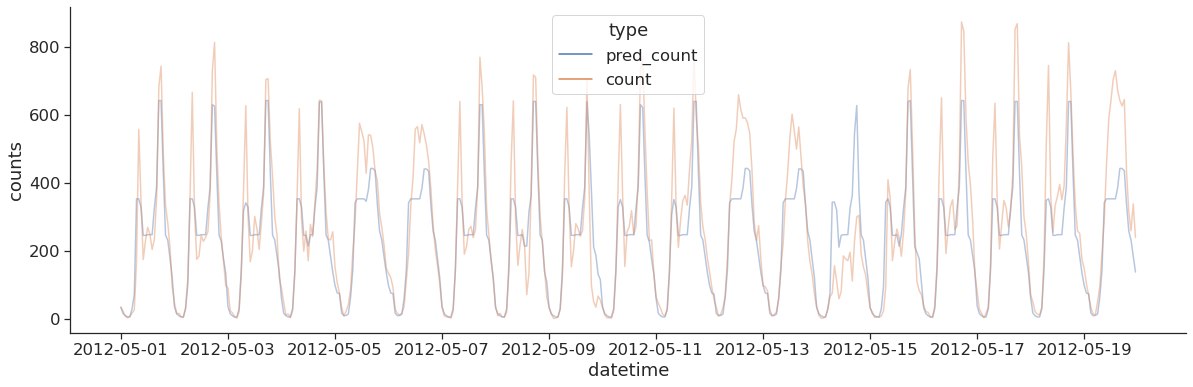

In [388]:
plt.figure(figsize = (20,6))


sns.lineplot(
    data = check_long.loc[(check_long.datetime > '2012-4-30') & (check_long.datetime < '2012-5-31'), :],
    x = 'datetime',
    y = 'counts',
    hue = 'type',
    alpha = 0.4)
sns.despine()

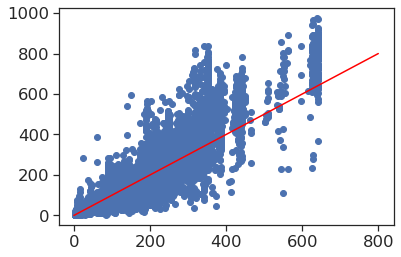

In [389]:
# sns.lmplot(data = check_df,
# x = 'pred_count',
# y = 'count',
# line_kws={'color':'red'})


plt.scatter(x = check_df['pred_count'], y = check_df['count'])
plt.plot([0,800], [0,800], c = 'red')

## Poisson 

In [390]:


make_model = make_pipeline(
    
        transformers,
        PoissonRegressor(max_iter = 5000, alpha = 0.2)
        # LinearRegression()
        # RandomForestRegressor(max_depth=6,random_state=42)
        
)


pomod = make_model.fit(X_train, y_train.values.ravel())

# pomod = make_model.fit(X_train, np.log1p(y_train.values.ravel()))




### Validation

In [391]:
print(round(pomod.score(X_train, y_train.values.ravel()),2) , round(pomod.score(X_test, y_test.values.ravel()),2))

r2_score(y_train.values.ravel(), pomod.predict(X_train))


0.58 0.58


0.5061824896026152

In [392]:
from sklearn.metrics import mean_squared_log_error

np.sqrt(mean_squared_log_error(y_test.values.ravel(), pomod.predict(X_test)))

0.9561674506028705

In [393]:
## get predictions and back transform


check_df = pd.concat(
    [rentals['datetime'],
    pd.Series(pomod.predict(rentals[predictors]), name = 'pred_count'),
    rentals[outcome]
    ],
    axis = 1)

print(check_df.columns)

check_long = pd.melt(check_df, id_vars = ('datetime',), var_name='type', value_name='counts')

check_long.head()


Index(['datetime', 'pred_count', 'count'], dtype='object')


,datetime,type,counts
0,2011-01-01 00:00:00,pred_count,18.851539
1,2011-01-01 01:00:00,pred_count,18.990650
2,2011-01-01 02:00:00,pred_count,20.247338
3,2011-01-01 03:00:00,pred_count,22.832038
4,2011-01-01 04:00:00,pred_count,26.548408


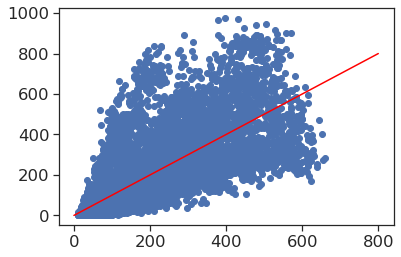

In [394]:
# sns.lmplot(data = check_df,
# x = 'pred_count',
# y = 'count',
# line_kws={'color':'red'})



plt.scatter(x = check_df['pred_count'], y = check_df['count'])
plt.plot([0,800], [0,800], c = 'red')

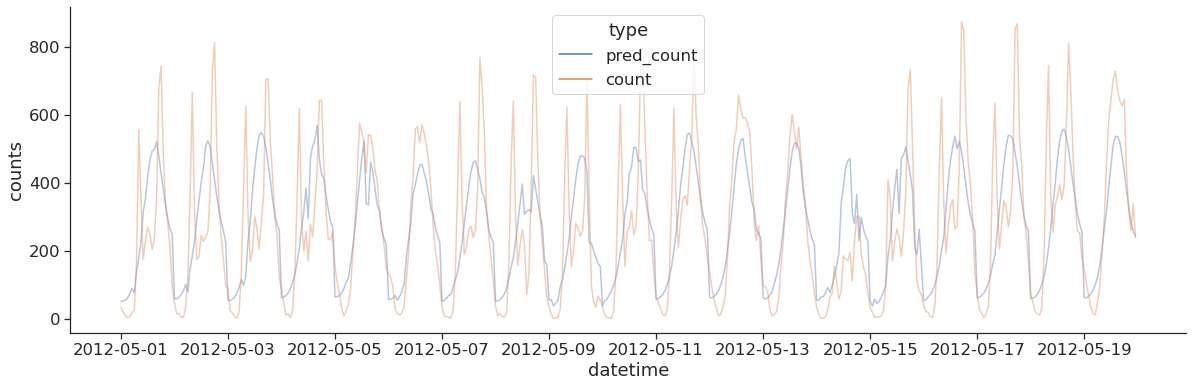

In [395]:
plt.figure(figsize = (20,6))


sns.lineplot(
    data = check_long.loc[(check_long.datetime > '2012-4-30') & (check_long.datetime < '2012-5-31'), :],
    x = 'datetime',
    y = 'counts',
    hue = 'type',
    alpha = 0.4)
sns.despine()

<AxesSubplot:xlabel='datetime', ylabel='counts'>

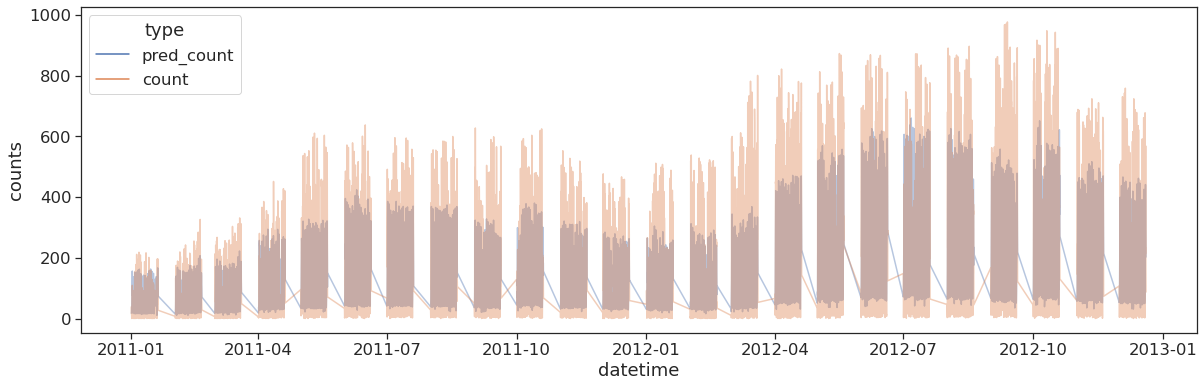

In [348]:
plt.figure(figsize = (20,6))

sns.lineplot(
    data = check_long,
    x = 'datetime',
    y = 'counts',
    hue = 'type',
    alpha = 0.4)


## With CV search

In [399]:
from sklearn.dummy import DummyRegressor

pipe = Pipeline(
    [
        ("transform", transformers),
        ("regressor", DummyRegressor()),
    ]
)


In [403]:
from sklearn.model_selection import GridSearchCV
param_grid = [
    {"regressor": (RandomForestRegressor(),)},
    {"regressor": (PoissonRegressor(),),
    "regressor__max_iter": (3000,)}

]

grid = GridSearchCV(
    pipe,
    cv=10,
    n_jobs=1,
    param_grid=param_grid,
    scoring="r2")

grid.fit(X_train, y_train.values.ravel())

/home/alex/.conda/envs/spiced/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:323: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('transform',
                                        ColumnTransformer(transformers=[('hour_trans',
                                                                         FunctionTransformer(func=<function cyclic_trans at 0x7fa007574820>,
                                                                                             kw_args={'cycle': 24}),
                                                                         'hour'),
                                                                        ('month_trans',
                                                                         FunctionTransformer(func=<function cyclic_trans at 0x7fa007574820>,
                                                                                             kw_args={'cycle': 12}),
                                                                         'month'),
                                                                       

In [402]:
grid.cv_results_

{'mean_fit_time': array([2.92894073, 0.86869595]),
 'std_fit_time': array([0.24953945, 0.04846424]),
 'mean_score_time': array([0.03728976, 0.01642468]),
 'std_score_time': array([0.0098638 , 0.00074506]),
 'param_regressor': masked_array(data=[RandomForestRegressor(), PoissonRegressor()],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'param_regressor__max_iter': masked_array(data=[--, 1000],
              mask=[ True, False],
        fill_value='?',
             dtype=object),
 'params': [{'regressor': RandomForestRegressor()},
  {'regressor': PoissonRegressor(), 'regressor__max_iter': 1000}],
 'split0_test_score': array([0.91670116, 0.48082514]),
 'split1_test_score': array([0.93793715, 0.55347555]),
 'split2_test_score': array([0.93560837, 0.50522342]),
 'split3_test_score': array([0.94555608, 0.51012292]),
 'split4_test_score': array([0.93136447, 0.46402162]),
 'split5_test_score': array([0.92578103, 0.47215367]),
 'split6_test_score': arra

In [457]:
from sklearn.model_selection import GridSearchCV
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import Lasso


pipe_trans = Pipeline(
    [
        ("transform", transformers),
        ('model_y', TransformedTargetRegressor(
            regressor = DummyRegressor(),
            func=None,
            inverse_func=None,
            check_inverse=False)
        )
    ]
)



param_grid = [

    # Random Forest
    {
        "model_y__regressor": (RandomForestRegressor(),),
        "model_y__regressor__max_depth": (3,6,9,12),
        "model_y__func" : (None,),
        "model_y__inverse_func" : (None,)
    },

    # Lasso
    {
        "model_y__regressor": (Lasso(),),
        "model_y__func" : (None,),
        "model_y__inverse_func" : (None,),
        "model_y__regressor__alpha": (1, 10),
        "model_y__regressor__max_iter": (5000,)
    },

    # Poisson
    {
        "model_y__regressor": (PoissonRegressor(),),
        "model_y__func" : (None,),
        "model_y__inverse_func" : (None,),
        "model_y__regressor__max_iter": (5000,)
        }

]


grid = GridSearchCV(
    pipe_trans,
    cv=10,
    n_jobs=1,
    param_grid=param_grid,
    scoring="r2")

grid.fit(X_train, y_train.values.ravel())

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('transform',
                                        ColumnTransformer(transformers=[('hour_trans',
                                                                         FunctionTransformer(func=<function cyclic_trans at 0x7fa007574820>,
                                                                                             kw_args={'cycle': 24}),
                                                                         'hour'),
                                                                        ('month_trans',
                                                                         FunctionTransformer(func=<function cyclic_trans at 0x7fa007574820>,
                                                                                             kw_args={'cycle': 12}),
                                                                         'month'),
                                                                       

In [502]:
pd.DataFrame(grid.cv_results_)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model_y__func,param_model_y__inverse_func,param_model_y__regressor,param_model_y__regressor__max_depth,param_model_y__regressor__alpha,param_model_y__regressor__max_iter,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,1.098832,0.274437,0.030699,0.002465,None,None,RandomForestRegressor(max_depth=12),3,NaN,NaN,...,0.573322,0.566523,0.611255,0.567979,0.600715,0.538440,0.624959,0.578288,0.027898,4
1,1.742887,0.206043,0.039196,0.006339,None,None,RandomForestRegressor(max_depth=12),6,NaN,NaN,...,0.857288,0.844656,0.853587,0.817687,0.864439,0.839563,0.846032,0.844802,0.016151,3
2,2.438045,0.162984,0.042826,0.007762,None,None,RandomForestRegressor(max_depth=12),9,NaN,NaN,...,0.926466,0.910917,0.913446,0.908286,0.917506,0.921466,0.914022,0.915084,0.008013,2
3,3.175715,0.136825,0.051927,0.007603,None,None,RandomForestRegressor(max_depth=12),12,NaN,NaN,...,0.944078,0.924504,0.924996,0.923929,0.929805,0.942612,0.930528,0.930478,0.008632,1
4,0.046147,0.004998,0.017759,0.002448,None,None,Lasso(),NaN,1,5000,...,0.505828,0.485675,0.495982,0.502226,0.520753,0.538413,0.530614,0.512549,0.020503,5
5,0.048376,0.009374,0.018426,0.002061,None,None,Lasso(),NaN,10,5000,...,0.449026,0.441534,0.441962,0.451124,0.482734,0.483356,0.486565,0.465854,0.022101,7
6,3.911071,0.864207,0.025850,0.004452,None,None,PoissonRegressor(),NaN,NaN,5000,...,0.509693,0.463473,0.472787,0.476640,0.507663,0.525956,0.526189,0.502504,0.027290,6


In [459]:
# grid.cv_results_['param_model_y__regressor'][3]
grid.cv_results_['mean_test_score']


array([0.57828776, 0.84480238, 0.91508356, 0.93047828, 0.51254869,
       0.46585416, 0.50250446])

In [470]:
# grid.best_estimator_.score(X_test, y_test)
# grid.best_estimator_.score(X_train, y_train)

# r2_score(y_test, grid.best_estimator_.predict(X_test))
r2_score(y_train, grid.best_estimator_.predict(X_train))



0.9760674626718443

## Kaggle Submission prep

In [479]:
# read test data

path_data_kaggle = "../01_data/test.csv"

x_test_kaggle = pd.read_csv(path_data_kaggle)

In [475]:
x_test_kaggle.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [481]:
x_test_kaggle.shape

(6493, 9)

apply pre-processing:

- bump workingday +1
- merge weather into 3 classes
- add time features and bump hour +1

In [482]:
x_test_kaggle['datetime'] = pd.to_datetime(x_test_kaggle['datetime'])
x_test_kaggle.weather = x_test_kaggle.weather.replace(4, 3)
x_test_kaggle['workingday_adj'] = x_test_kaggle['workingday'] + 1


time_atts = make_time_cols(time_att= ['year', 'dayofyear', 'month', 'day', 'weekday', 'hour'], time_series = x_test_kaggle.datetime)

x_test_kaggle = pd.concat([x_test_kaggle, time_atts], axis = 1)
x_test_kaggle['hour'] = x_test_kaggle['hour'] + 1 # for polyfeatures

In [483]:
x_test_kaggle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   datetime        6493 non-null   datetime64[ns]
 1   season          6493 non-null   int64         
 2   holiday         6493 non-null   int64         
 3   workingday      6493 non-null   int64         
 4   weather         6493 non-null   int64         
 5   temp            6493 non-null   float64       
 6   atemp           6493 non-null   float64       
 7   humidity        6493 non-null   int64         
 8   windspeed       6493 non-null   float64       
 9   workingday_adj  6493 non-null   int64         
 10  year            6493 non-null   int64         
 11  dayofyear       6493 non-null   int64         
 12  month           6493 non-null   int64         
 13  day             6493 non-null   int64         
 14  weekday         6493 non-null   int64         
 15  hour

In [485]:
y_test_pred = pd.Series(grid.best_estimator_.predict(x_test_kaggle), name = 'count')

In [497]:
kaggle_out = pd.concat([x_test_kaggle[['datetime']], y_test_pred], axis = 1)

In [498]:
kaggle_out.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  6493 non-null   datetime64[ns]
 1   count     6493 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 101.6 KB


In [499]:
kaggle_out.head()

,datetime,count
0,2011-01-20 00:00:00,14.175110
1,2011-01-20 01:00:00,4.240892
2,2011-01-20 02:00:00,2.281289
3,2011-01-20 03:00:00,2.633119
4,2011-01-20 04:00:00,2.421854


In [501]:
kaggle_out.to_csv("../01_data/kaggle_test.csv", header = True, index = False)

TypeError: _quantile_dispatcher() missing 1 required positional argument: 'a'